In [ ]:
import tensorflow as tf
from tensorflow import keras
import os
import tarfile 
import matplotlib.pyplot as plt
import pandas as pd

# Extract and Load Data

In [ ]:
tarfile_path = './dataset.tar'
with tarfile.TarFile(tarfile_path) as f:
  f.extractall()

In [ ]:
batch_size = 128

train_ds = keras.utils.image_dataset_from_directory(
    './Dataset/train',
    label_mode='int',
    batch_size=64,
    image_size=(224, 224),
)

val_ds = keras.utils.image_dataset_from_directory(
    './Dataset/val',
    label_mode='int',
    batch_size=64,
    image_size=(224, 224),
    shuffle = False
)

# Create model

## Get Feature Extractor

In [ ]:
mobile_net_feature_extractor = keras.applications.mobilenet_v2.MobileNetV2(
    alpha=1.0,
    include_top=False, 
    weights='imagenet', 
    input_shape = (224,224,3), 
    pooling='avg'
    )
for layer in mobile_net_feature_extractor.layers:
  layer.trainable = False

## Helper Functions to create models

In [ ]:
def create_baseline_model(feature_extractor, classes = 1000, image_size = 224):
  inp = keras.Input(shape = (image_size, image_size,3))
  x = keras.applications.mobilenet_v2.preprocess_input(inp)
  x = feature_extractor(x)
  out = keras.layers.Dense(classes, activation = 'softmax')(x)

  return keras.models.Model(inputs=[inp], outputs= [out])

# Training

In [ ]:
model_name = 'baseline'
epochs = 1000

In [ ]:
model = create_baseline_model(mobile_net_feature_extractor)

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 15, verbose = 1),
    tf.keras.callbacks.ModelCheckpoint(filepath = f'./{model_name}.h5', monitor = 'val_loss', save_best_only = True, verbose = 1),
    tf.keras.callbacks.LearningRateScheduler(keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.045, decay_steps=1, decay_rate=0.98))
    ]

In [ ]:
model.compile(
      optimizer= keras.optimizers.RMSprop(
          learning_rate = 0.045,
          momentum=0.9,
          rho = 0.9
          ),
      loss = keras.losses.SparseCategoricalCrossentropy(), 
      metrics=['accuracy']
      )

history = model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = epochs,
    callbacks = callbacks,
    validation_data = val_ds
    )

## Train plots

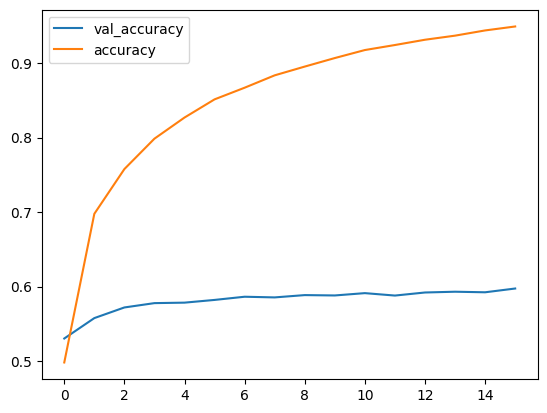

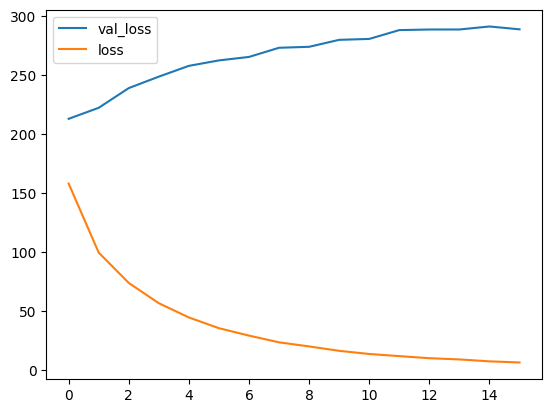

In [29]:
pd.DataFrame(history.history).to_csv(f'{model_name}.csv', index = False)

df = pd.read_csv('baseline.csv')

df[['val_accuracy', 'accuracy']].plot()
df[['val_loss', 'loss']].plot()


# Test result

In [ ]:
predictions = model.predict(val_ds)
